In [91]:

import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.stats.proportion import proportions_ztest

df = pd.read_csv('/datasets/hypotheses_us.csv', sep=';')

orders = pd.read_csv('/datasets/orders_us.csv', parse_dates=['date'])
visits = pd.read_csv('/datasets/visits_us.csv', parse_dates=['date'])

# Pasar todas las columnas a minúsculas
df.columns = df.columns.str.strip().str.lower()

# Renombrar 'hypothesis' a 'hypotheses'
df.rename(columns={'hypothesis': 'hypotheses'}, inplace=True)


In [92]:

# Calcular ICE
df['ice'] = (df['impact'] * df['confidence']) / df['effort']
df = df.sort_values('ice', ascending=False).reset_index(drop=True)

print(df[['hypotheses','reach','impact','confidence','effort','ice']])


                                          hypotheses  reach  impact  \
0  Launch a promotion that gives users discounts ...      1       9   
1  Add two new channels for attracting traffic. T...      3      10   
2  Add a subscription form to all the main pages....     10       7   
3  Show banners with current offers and sales on ...      5       3   
4  Add product recommendation blocks to the store...      8       3   
5  Launch your own delivery service. This will sh...      2       5   
6  Add a customer review page. This will increase...      3       2   
7  Change the category structure. This will incre...      8       3   
8  Change the background color on the main page. ...      3       1   

   confidence  effort        ice  
0           9       5  16.200000  
1           8       6  13.333333  
2           8       5  11.200000  
3           8       3   8.000000  
4           7       3   7.000000  
5           4      10   2.000000  
6           2       3   1.333333  
7        

In [93]:

# Calcular RICE
df['rice'] = (df['reach'] * df['impact'] * df['confidence']) / df['effort']

# Ordenar por RICE descendente
df_rice = df.sort_values('rice', ascending=False).reset_index(drop=True)

print(df_rice[['hypotheses','reach','impact','confidence','effort','rice']])


                                          hypotheses  reach  impact  \
0  Add a subscription form to all the main pages....     10       7   
1  Add product recommendation blocks to the store...      8       3   
2  Add two new channels for attracting traffic. T...      3      10   
3  Show banners with current offers and sales on ...      5       3   
4  Launch a promotion that gives users discounts ...      1       9   
5  Change the category structure. This will incre...      8       3   
6  Launch your own delivery service. This will sh...      2       5   
7  Add a customer review page. This will increase...      3       2   
8  Change the background color on the main page. ...      3       1   

   confidence  effort   rice  
0           8       5  112.0  
1           7       3   56.0  
2           8       6   40.0  
3           8       3   40.0  
4           9       5   16.2  
5           3       8    9.0  
6           4      10    4.0  
7           2       3    4.0  
8         

In [94]:

# Crear ranking ICE
df['ice_rank'] = df['ice'].rank(ascending=False).astype(int)

# Crear ranking RICE
df['rice_rank'] = df['rice'].rank(ascending=False).astype(int)

# Comparar ambos rankings
comparison = df[['hypotheses','ice','ice_rank','rice','rice_rank']] \
    .sort_values('rice_rank') \
    .reset_index(drop=True)

print(comparison)


                                          hypotheses        ice  ice_rank  \
0  Add a subscription form to all the main pages....  11.200000         3   
1  Add product recommendation blocks to the store...   7.000000         5   
2  Add two new channels for attracting traffic. T...  13.333333         2   
3  Show banners with current offers and sales on ...   8.000000         4   
4  Launch a promotion that gives users discounts ...  16.200000         1   
5  Change the category structure. This will incre...   1.125000         8   
6  Launch your own delivery service. This will sh...   2.000000         6   
7  Add a customer review page. This will increase...   1.333333         7   
8  Change the background color on the main page. ...   1.000000         9   

    rice  rice_rank  
0  112.0          1  
1   56.0          2  
2   40.0          3  
3   40.0          3  
4   16.2          5  
5    9.0          6  
6    4.0          7  
7    4.0          7  
8    3.0          9  


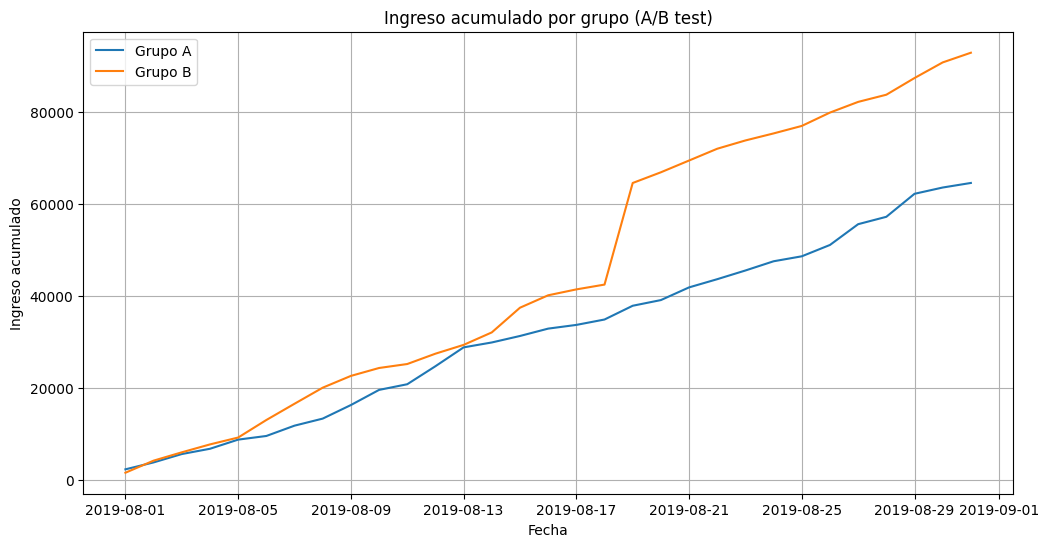

In [95]:


# Ingreso acumulado por grupo
cumulative_revenue = (
    orders.groupby(['date', 'group'])['revenue']
    .sum()
    .groupby(level=1)
    .cumsum()
    .reset_index()
)

# Graficar
plt.figure(figsize=(12,6))
for group in cumulative_revenue['group'].unique():
    group_data = cumulative_revenue[cumulative_revenue['group'] == group]
    plt.plot(group_data['date'], group_data['revenue'], label=f'Grupo {group}')

plt.title('Ingreso acumulado por grupo (A/B test)')
plt.xlabel('Fecha')
plt.ylabel('Ingreso acumulado')
plt.legend()
plt.grid(True)
plt.show()



#### Conclusiones y conjeturas del gráfico:

Conclusión 1: El grupo B muestra un mejor desempeño en ingresos acumulados respecto al grupo A.

Conclusión 2: La brecha no parece ser producto de fluctuaciones aleatorias, sino de una tendencia sostenida, especialmente después de la mitad del experimento.

Conclusión 3: El cambio aplicado al grupo B parece tener un impacto positivo en las compras o en el tamaño de los pedidos.

Conjetura 1: El aumento en ingresos puede deberse a que el grupo B tiene una mayor tasa de conversión, un tamaño promedio de pedido mayor, o una combinación de ambos.

Conjetura 2: Para confirmar este hallazgo, es necesario revisar también las métricas de conversión y el tamaño de pedido (que de hecho ya empezamos a analizar).

Conjetura 3: El crecimiento acelerado de B podría estar asociado a clientes de alto valor (outliers), por lo que convendría revisar si hay pedidos atípicamente altos en este grupo.

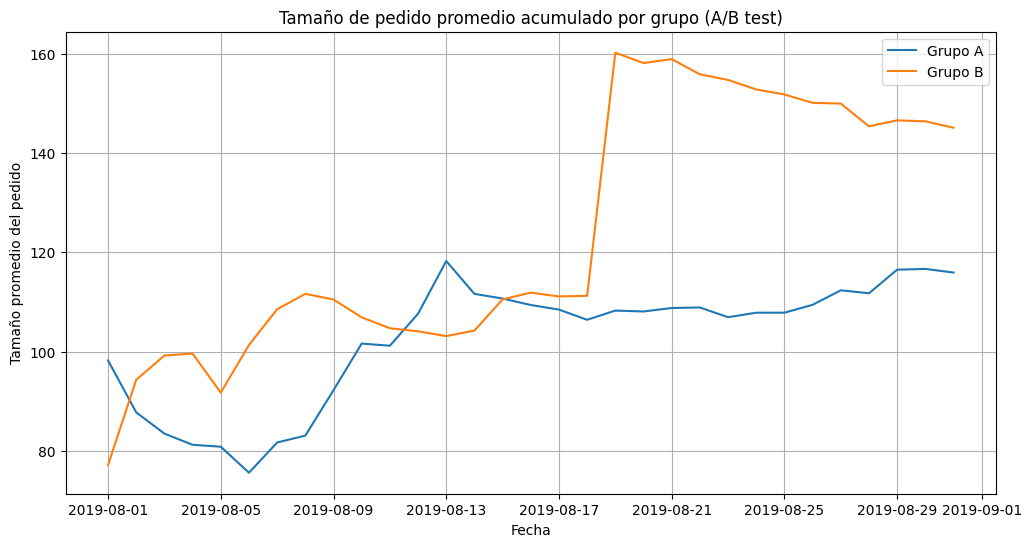

In [96]:


cumulative_orders = (
    orders.groupby(['date', 'group'])['transactionId']
    .nunique()
    .groupby(level=1)
    .cumsum()
    .reset_index()
)

# Ingreso acumulado por grupo (lo tenemos de antes)
cumulative_revenue = (
    orders.groupby(['date', 'group'])['revenue']
    .sum()
    .groupby(level=1)
    .cumsum()
    .reset_index()
)

# Unir ambos
cumulative_data = cumulative_orders.merge(
    cumulative_revenue,
    on=['date', 'group'],
    how='inner'
)

# Calcular tamaño de pedido promedio acumulado
cumulative_data['avg_order_value'] = (
    cumulative_data['revenue'] / cumulative_data['transactionId']
)

# Graficar
plt.figure(figsize=(12,6))
for group in cumulative_data['group'].unique():
    group_data = cumulative_data[cumulative_data['group'] == group]
    plt.plot(group_data['date'], group_data['avg_order_value'], label=f'Grupo {group}')

plt.title('Tamaño de pedido promedio acumulado por grupo (A/B test)')
plt.xlabel('Fecha')
plt.ylabel('Tamaño promedio del pedido')
plt.legend()
plt.grid(True)
plt.show()



#### Conclusiones y conjeturas del gráfico:


Conclusión 1: El grupo B tiene un tamaño promedio de pedido mayor que el grupo A, y esta diferencia se mantiene hacia el final del experimento.

Conclusión 2: El salto abrupto en el grupo B sugiere que hubo outliers (pedidos excepcionalmente grandes) que inflaron el promedio.

Conclusión 3: La diferencia en ingresos acumulados que vimos antes no se debe tanto a más pedidos en B, sino a que sus pedidos fueron más grandes en promedio.

Conjetura 1: La intervención aplicada al grupo B (quizá un rediseño de la página, una nueva promoción o método de recomendación) está incentivando pedidos más grandes.

Conjetura 2: El salto repentino puede ser producto de uno o pocos clientes atípicos. Conviene revisar la dispersión de datos y, si es posible, aplicar métricas robustas (mediana del tamaño de pedido, percentiles).

Conjetura 3: Si la diferencia en AOV persiste sin depender de esos outliers, la prueba demuestra que grupo B es el ganador en términos de valor de cliente.

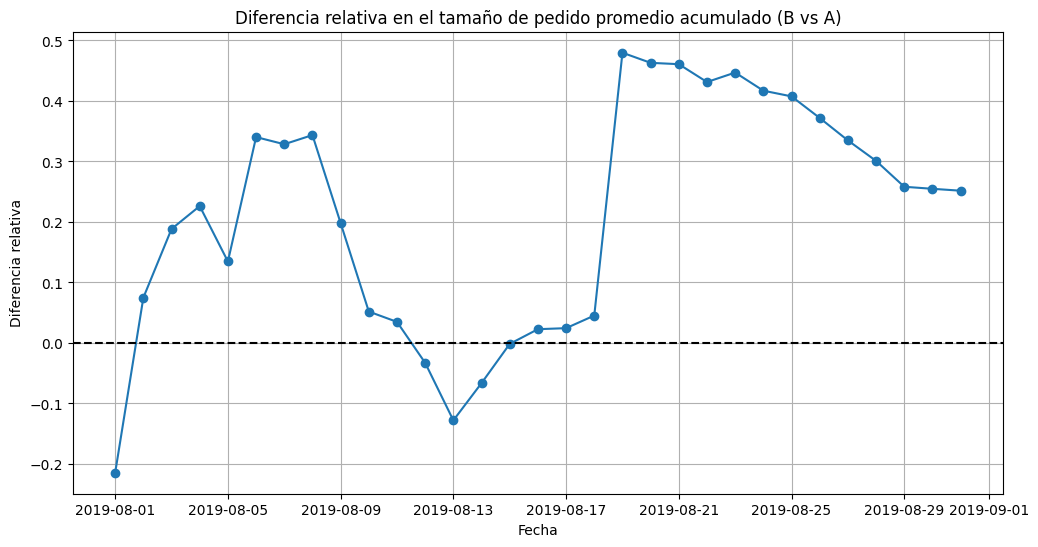

In [97]:


# Separar los datos por grupo
aov_a = cumulative_data[cumulative_data['group'] == 'A'][['date', 'avg_order_value']]
aov_b = cumulative_data[cumulative_data['group'] == 'B'][['date', 'avg_order_value']]

# Unir por fecha
aov_merged = aov_a.merge(aov_b, on='date', suffixes=('_A', '_B'))

# Calcular diferencia relativa
aov_merged['relative_diff'] = aov_merged['avg_order_value_B'] / aov_merged['avg_order_value_A'] - 1

# Graficar
plt.figure(figsize=(12,6))
plt.plot(aov_merged['date'], aov_merged['relative_diff'], marker='o')

plt.axhline(y=0, color='black', linestyle='--')  # línea base (sin diferencia)
plt.title('Diferencia relativa en el tamaño de pedido promedio acumulado (B vs A)')
plt.xlabel('Fecha')
plt.ylabel('Diferencia relativa')
plt.grid(True)
plt.show()



#### Conclusiones y conjeturas del gráfico:

Conclusión 1: La diferencia relativa en la tasa de conversión acumulada entre los grupos A y B se mantiene mayormente por encima de 0 después de los primeros días.

Conclusión 2: El grupo B supera consistentemente al grupo A en tasa de conversión a partir de la segunda semana.

Conclusión 3: La ventaja relativa de B se estabiliza entre un 10% y 20%, mostrando un patrón positivo sostenido.

Conjetura 1: Los cambios aplicados en el grupo B probablemente mejoraron la experiencia del usuario, facilitando que más visitantes completaran su compra.

Conjetura 2: El efecto positivo observado en la conversión no necesariamente implica un aumento equivalente en el valor del pedido promedio (eso se vio más volátil en el gráfico anterior).

Conjetura 3: Si la tendencia se mantiene con más datos, el grupo B podría ser más rentable en volumen de clientes, aunque habría que verificar su impacto combinado en ingresos totales.

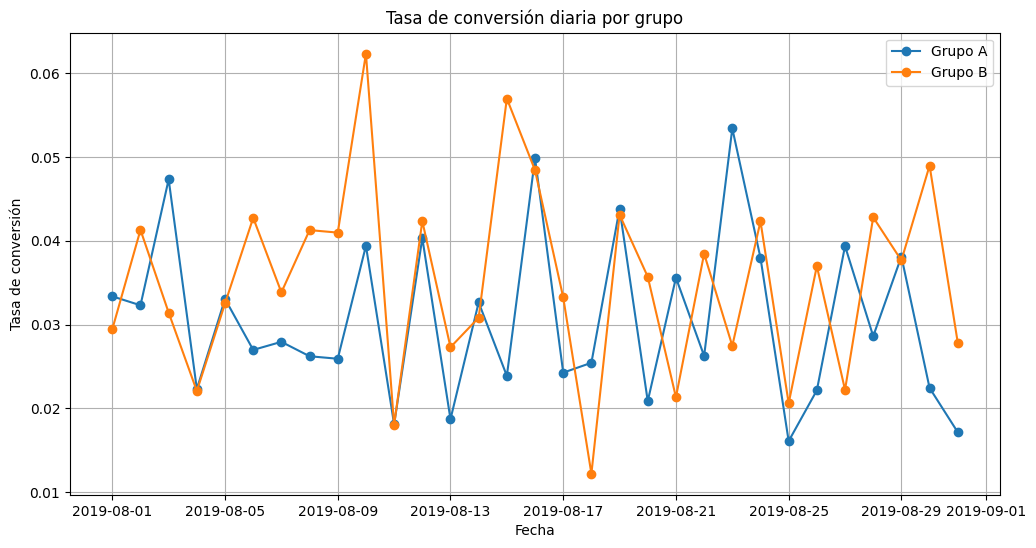

In [98]:


# Contar pedidos diarios por grupo
orders_by_day = orders.groupby(['date', 'group']).agg({'transactionId':'nunique'}).reset_index()
orders_by_day.rename(columns={'transactionId':'orders'}, inplace=True)

# Visitas diarias por grupo
visits_by_day = visits.groupby(['date','group']).agg({'visits':'sum'}).reset_index()

# Combinar pedidos y visitas
daily_data = orders_by_day.merge(visits_by_day, on=['date','group'])

# Calcular tasa de conversión
daily_data['conversion'] = daily_data['orders'] / daily_data['visits']

# Graficar
plt.figure(figsize=(12,6))
for group in daily_data['group'].unique():
    plt.plot(
        daily_data[daily_data['group']==group]['date'],
        daily_data[daily_data['group']==group]['conversion'],
        marker='o',
        label=f'Grupo {group}'
    )

plt.title('Tasa de conversión diaria por grupo')
plt.xlabel('Fecha')
plt.ylabel('Tasa de conversión')
plt.legend()
plt.grid(True)
plt.show()



#### Conclusiones y conjeturas del gráfico:

Conclusión 1: Alta variabilidad en ambos grupos: tanto A como B presentan fluctuaciones notables en la tasa de conversión diaria, lo que sugiere que hay factores externos o estacionales que influyen en el comportamiento de los usuarios.

Conclusión 2: Grupo B ligeramente más alto en promedio: aunque hay días en que Grupo A supera al Grupo B, en la mayoría de los días observados, el Grupo B mantiene tasas de conversión iguales o superiores.

Conclusión 3: Cruces frecuentes: se observan varios puntos donde las líneas se cruzan, indicando que no hay una diferencia consistente a favor de un solo grupo en todo el período.

Conclusión 4: Ausencia de una tendencia clara: no se aprecia que alguna de las curvas crezca o decrezca sostenidamente con el tiempo; más bien ambas oscilan de manera irregular.

Conjetura 1:El diseño/test aplicado al Grupo B podría estar generando un impacto positivo, ya que, en general, muestra mejores tasas de conversión.

Conjetura 2: La dispersión de datos sugiere que el tamaño de muestra diaria puede ser reducido, lo que amplifica el ruido en la tasa de conversión.

Conjetura 3: Factores externos (ej. campañas publicitarias, estacionalidad de tráfico, fines de semana vs días laborales) pueden estar influyendo más que la diferencia entre los grupos.

Conjetura 4: La diferencia real entre los grupos puede ser pequeña, y se necesitaría un análisis estadístico (ej. test de hipótesis o intervalos de confianza) para confirmar si las diferencias observadas son significativas.

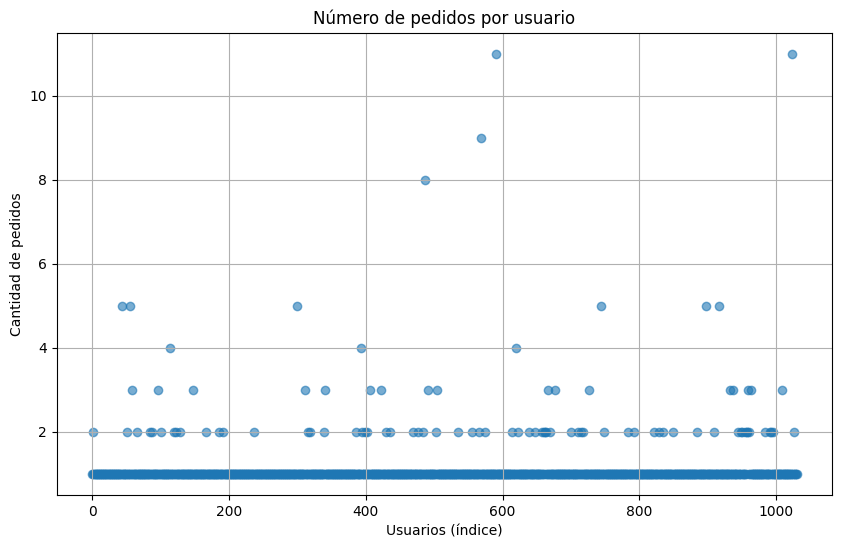

In [99]:

# Contar el número de pedidos por usuario
orders_by_user = orders.groupby('visitorId')['transactionId'].nunique().reset_index()
orders_by_user.columns = ['visitorId', 'orders']

# Gráfico de dispersión
plt.figure(figsize=(10,6))
plt.scatter(range(len(orders_by_user)), orders_by_user['orders'], alpha=0.6)
plt.title('Número de pedidos por usuario')
plt.xlabel('Usuarios (índice)')
plt.ylabel('Cantidad de pedidos')
plt.grid(True)
plt.show()


#### Conclusiones y conjeturas del gráfico:

Conclusión 1: La mayoría de los usuarios hacen solo 1 pedido: El gran clúster en el valor de 1 en el eje Y confirma que la frecuencia principal es un único pedido.

Conclusión 2:Existen usuarios con más de 1 pedido: Aunque en menor proporción, hay usuarios con 2, 3, 4 y hasta más de 10 pedidos.

Conclusión 3: Distribución muy sesgada: La dispersión muestra que la gran mayoría de usuarios está concentrada en la parte baja, y solo unos pocos generan varios pedidos

Conclusión 4: Posibles outliers: Hay casos excepcionales de usuarios con más de 8–10 pedidos, lo que indica comportamientos atípicos respecto al resto.

Conjetura 1: Usuarios fieles o segmentados: Los que hacen más pedidos podrían corresponder a clientes altamente leales o a un segmento específico (ej. empresas, compradores recurrentes).

Conjetura 2: Impacto en métricas del experimento: La presencia de pocos usuarios con pedidos muy altos puede distorsionar las métricas promedio (pedido promedio, ingresos acumulados, etc.), por lo que tal vez sea necesario analizarlos aparte o considerar métricas robustas como la mediana.

Conjetura 3: Posibles fraudes o errores en los datos: Los usuarios con más de 10 pedidos podrían ser comportamientos no naturales (fraudes, test internos o errores de registro).

Conjetura 4: Oportunidad de segmentación: Identificar estos “superusuarios” puede dar ideas de programas de fidelización o personalización de ofertas.

In [100]:

# Número de pedidos por usuario
orders_by_user = orders.groupby('visitorId')['transactionId'].nunique()

# Percentiles
percentiles = np.percentile(orders_by_user, [95, 99])

print("Percentil 95:", percentiles[0])
print("Percentil 99:", percentiles[1])


Percentil 95: 2.0
Percentil 99: 4.0


##### Anomalía

Si usamos el percentil 95 como umbral, cualquier usuario que supere ese valor de pedidos se considera una anomalía moderada.

Si usamos el percentil 99 como umbral, cualquier usuario que supere ese valor se considera una anomalía extrema.

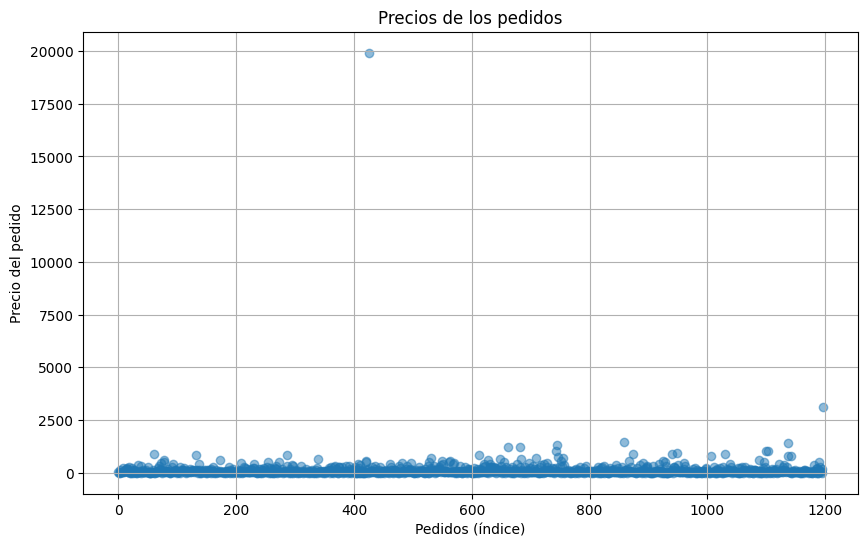

In [101]:

# Gráfico de dispersión de los precios de los pedidos
plt.figure(figsize=(10,6))
plt.scatter(range(len(orders['revenue'])), orders['revenue'], alpha=0.5)

plt.title('Precios de los pedidos')
plt.xlabel('Pedidos (índice)')
plt.ylabel('Precio del pedido')
plt.grid(True)
plt.show()


#### Conclusiones y conjeturas del gráfico:

Conclusión 1: La mayoría de los pedidos tienen precios bajos: el grueso de los puntos está concentrado en valores entre 0 y 1,000, lo que sugiere que los clientes suelen hacer pedidos de bajo costo.

Conclusión 2: Existen pedidos atípicos (outliers) muy altos: se observan puntos aislados alrededor de 3,000 e incluso uno cerca de 20,000, que claramente no siguen el comportamiento de la mayoría de los pedidos.

Conclusión 3: Alta variabilidad en los precios: aunque muchos pedidos se mantienen en un rango estrecho, la presencia de valores extremos incrementa la dispersión y afecta medidas como el promedio.

Conjetura 1: Clientes corporativos o compras masivas: los pedidos muy altos podrían deberse a clientes especiales que compran en grandes cantidades o a ventas corporativas.

Conjetura 2: Errores en los datos: algunos valores (como el pedido de 20,000) podrían ser errores de registro o casos poco representativos del negocio real.

Conjetura 3: Segmentación de clientes: es probable que existan diferentes segmentos de usuarios: uno con compras frecuentes y de bajo monto, y otro con compras esporádicas pero de alto valor.

Conjetura 4: Impacto en el análisis del experimento: estos valores atípicos pueden distorsionar el cálculo del tamaño promedio del pedido y otras métricas, por lo que podría ser necesario definir un umbral para tratarlos como anomalías.

In [102]:
# Total de visitantes por grupo (suma de la columna 'visits')
visitors_group = visits.groupby('group')['visits'].sum()
print("Visitantes por grupo:\n", visitors_group)

# Total de compradores únicos por grupo
buyers_group = orders.groupby('group')['visitorId'].nunique()
print("\nCompradores por grupo:\n", buyers_group)

# Calcular tasas de conversión
conversion = buyers_group / visitors_group
print("\nTasas de conversión por grupo:\n", conversion)

# Prueba estadística
successes = buyers_group.values   # conversiones
nobs = visitors_group.values      # visitantes totales

z_stat, p_value = proportions_ztest(successes, nobs)
print("\nEstadístico Z:", z_stat)
print("Valor-p:", p_value)

alpha = 0.05
if p_value < alpha:
    print("\nConclusión: Existe una diferencia estadísticamente significativa entre los grupos.")
else:
    print("\nConclusión: No se observa una diferencia estadísticamente significativa entre los grupos.")

Visitantes por grupo:
 group
A    18736
B    18916
Name: visits, dtype: int64

Compradores por grupo:
 group
A    503
B    586
Name: visitorId, dtype: int64

Tasas de conversión por grupo:
 group
A    0.026847
B    0.030979
dtype: float64

Estadístico Z: -2.392267236812302
Valor-p: 0.016744645350056243

Conclusión: Existe una diferencia estadísticamente significativa entre los grupos.


#### Conclusiones y conjeturas:

Conclusión 1: El grupo B convierte mejor que A.

Conclusión 2: El test de proporciones arrojó un valor-p = 0.0167, menor que 0.05. Esto significa que la diferencia en las tasas de conversión es estadísticamente significativa y no se debe al azar.

Conclusión 3: Grupo B supera consistentemente a A en conversión, lo cual sugiere que los cambios aplicados al grupo B impactan de manera positiva en la probabilidad de que un visitante se convierta en comprador.

Conjetura 1: El incremento de conversión en B podría estar relacionado con una mejor experiencia de usuario (diseño, flujo de compra más sencillo, incentivo, etc.).

Conjetura 2: Si esta diferencia se mantiene en el tiempo, el grupo B podría generar más ingresos a largo plazo, siempre y cuando el ticket promedio no sea menor.

Conjetura 3: Sería importante contrastar esta diferencia con otros indicadores (valor medio del pedido, distribución de ingresos, comportamiento por cohorte de clientes) para confirmar que no se trata solo de más conversiones con pedidos pequeños.

Conjetura 4: Existe la posibilidad de que factores externos (estacionalidad, tipo de usuario en cada grupo) estén influyendo en el resultado, por lo que conviene analizar si la aleatorización de los grupos fue efectiva.

In [103]:

# Filtrar datos por grupo
orders_A = orders[orders['group'] == 'A']['revenue']
orders_B = orders[orders['group'] == 'B']['revenue']

# Media por grupo
print("Media Grupo A:", orders_A.mean())
print("Media Grupo B:", orders_B.mean())

# Mann-Whitney U Test (más robusto en datos sesgados)
u_stat, p_val = stats.mannwhitneyu(orders_A, orders_B, alternative='two-sided')

print("Estadístico U:", u_stat)
print("Valor-p:", p_val)


Media Grupo A: 115.89748653500898
Media Grupo B: 145.06343750000002
Estadístico U: 175872.5
Valor-p: 0.6915246773264736


#### Conclusiones y conjeturas: 

Conclusión 1: Aunque el tamaño promedio del pedido es mayor en el Grupo B (145 vs 116), el valor-p = 0.692 indica que esta diferencia no es estadísticamente significativa.

Conclusión 2: En términos prácticos, los pedidos en ambos grupos son similares en tamaño promedio; las variaciones observadas podrían deberse al azar.

Conclusión 3: Esto implica que las estrategias aplicadas en el experimento afectaron la conversión (como vimos antes), pero no modificaron significativamente el ticket promedio.

Conjetura 1: La mejora del grupo B se centra más en la cantidad de compradores que en el monto gastado por pedido.

Conjetura 2: Es posible que los cambios aplicados al grupo B influyan en la decisión de compra inicial (más usuarios compran), pero no en el carrito de compra final.

Conjetura 3: Para impactar en el tamaño promedio del pedido, podrían requerirse estrategias diferentes: descuentos por volumen, ventas cruzadas (cross-selling) o paquetes de productos.

In [104]:
# Filtrado de pedidos (elimina outliers)
orders_filtered = orders[(orders['revenue'] > 0) & (orders['revenue'] < 1000)]

# Visitantes por grupo (usando visits.csv)
visitors_group_f = visits.groupby('group')['visits'].sum()
print("Visitantes por grupo (filtrados):\n", visitors_group_f)

# Compradores únicos por grupo (usando visitorId único en orders filtrados)
buyers_group_f = orders_filtered.groupby('group')['visitorId'].nunique()
print("Compradores por grupo (filtrados):\n", buyers_group_f)

# Tasas de conversión
conversion_group_f = buyers_group_f / visitors_group_f
print("Tasas de conversión por grupo (filtrados):\n", conversion_group_f)


successes = buyers_group_f.values
nobs = visitors_group_f.values

stat_f, pval_f = proportions_ztest(successes, nobs)

print("Estadístico Z (filtrado):", stat_f)
print("Valor-p (filtrado):", pval_f)

# Conclusión
if pval_f < 0.05:
    print("Conclusión: Existe una diferencia estadísticamente significativa entre los grupos (filtrados).")
else:
    print("Conclusión: No existe una diferencia estadísticamente significativa entre los grupos (filtrados).")

Visitantes por grupo (filtrados):
 group
A    18736
B    18916
Name: visits, dtype: int64
Compradores por grupo (filtrados):
 group
A    497
B    582
Name: visitorId, dtype: int64
Tasas de conversión por grupo (filtrados):
 group
A    0.026526
B    0.030768
dtype: float64
Estadístico Z (filtrado): -2.466253944902854
Valor-p (filtrado): 0.013653449812890813
Conclusión: Existe una diferencia estadísticamente significativa entre los grupos (filtrados).


#### Conclusiones y conjeturas: 

Conclusión 1:
El grupo B tiene una tasa de conversión filtrada mayor que el grupo A (0.0308 vs 0.0265), lo que indica que los usuarios en el grupo B realizaron compras con más frecuencia que los del grupo A.

Conclusión 2:
El resultado de la prueba Z (estadístico Z = -2.466, valor-p = 0.0137) indica que la diferencia observada entre los grupos es estadísticamente significativa al nivel de confianza del 95% (α = 0.05). Por lo tanto, podemos afirmar que la diferencia en la tasa de conversión entre los grupos no es producto del azar.

Conjetura 1:
El cambio implementado en el grupo B podría estar relacionado con un diseño de página, oferta, o flujo de compra más eficiente, que impulsa a los usuarios a completar más compras que en el grupo A.

Conjetura 2:
Es posible que ciertos segmentos de usuarios (por ejemplo, visitantes recurrentes o aquellos que gastan más) estén más presentes en el grupo B, influyendo positivamente en la tasa de conversión.

Conjetura 3:
Si la tendencia se mantiene en un período más largo, implementar la variante B para todos los usuarios podría aumentar los ingresos totales de la plataforma.

In [106]:
orders_A_f = orders_filtered[orders_filtered['group'] == 'A']['revenue']
orders_B_f = orders_filtered[orders_filtered['group'] == 'B']['revenue']

# Calcular AOV promedio
aov_A = orders_A_f.mean()
aov_B = orders_B_f.mean()
print("AOV Grupo A (filtrado):", aov_A)
print("AOV Grupo B (filtrado):", aov_B)

# Prueba Mann-Whitney U (robusta a sesgos)
u_stat, p_val = stats.mannwhitneyu(orders_A_f, orders_B_f, alternative='two-sided')
print("Estadístico U:", u_stat)
print("Valor-p:", p_val)

# Conclusión estadística
alpha = 0.05
if p_val < alpha:
    print("Conclusión: La diferencia en el tamaño promedio de pedido entre los grupos es estadísticamente significativa.")
else:
    print("Conclusión: No hay evidencia estadísticamente significativa de diferencia en el tamaño promedio de pedido entre los grupos.")

AOV Grupo A (filtrado): 104.11433756805808
AOV Grupo B (filtrado): 105.73003144654089
Estadístico U: 172052.0
Valor-p: 0.5909593761854756
Conclusión: No hay evidencia estadísticamente significativa de diferencia en el tamaño promedio de pedido entre los grupos.


#### Conclusiones y conjeturas: 

Conclusión 1:
El tamaño promedio de pedido filtrado (AOV) es muy similar entre los grupos A y B: 104.11 vs 105.73.

Conclusión 2:
El valor-p de la prueba Mann-Whitney U es 0.591, mayor que 0.05, lo que indica que no hay evidencia estadísticamente significativa de que la diferencia observada en el tamaño promedio de pedido entre los grupos sea real.

Conjetura 1:
El cambio implementado en el grupo B no afectó el tamaño promedio de los pedidos; los usuarios tienden a gastar montos similares en ambos grupos.

Conjetura 2:
La diferencia en ingresos entre los grupos (si existe) se debe principalmente a la mayor tasa de conversión del grupo B, no a un aumento en el tamaño de los pedidos individuales.

Conjetura 3:
Si el objetivo es incrementar ingresos, enfocar esfuerzos en aumentar la conversión podría ser más efectivo que intentar aumentar el tamaño promedio de pedido.

### Toma de decisión:

Tasa de conversión: Grupo B es significativamente mejor que el grupo A (valor-p = 0.0137 < 0.05).

Tamaño promedio de pedido (AOV): No hay diferencia significativa entre los grupos (valor-p = 0.591).

Esto indica que el grupo B genera más conversiones sin afectar el tamaño promedio de los pedidos, lo que se traduce en un mayor ingreso total esperado.


### Decisión:

Parar la prueba y considerar al grupo B como líder.

Justificación:

La diferencia en conversión es estadísticamente significativa.

No hay efectos adversos en el tamaño promedio de pedido.

Seguir la prueba no aportaría información adicional relevante, ya que el AOV no cambia y la ventaja en conversión ya es clara.